In [1]:
# nbi:hide_in
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

![image](http://gael-varoquaux.info/science/attachments/ica_pca/pca_on_non_gaussian_data.png)
# Intuition
In this example we are going to illustrate the idea of what PCA means, here we present the next data in 2D and we want to find a projection in 1D such that the maximum quantity of variability is preserved.

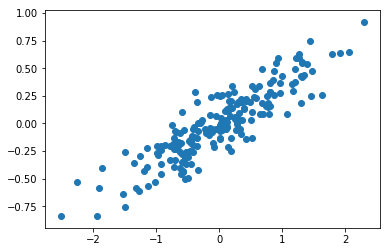

In [2]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T+10

# center the data in 0,0
X=X-np.mean(X, axis=0)

plt.scatter(X[:,0], X[:,1])

Let's remember that the projection of a vector $\vec{x}$ over another vector $\vec{v}$ is given by [take a look here](https://matthew-brett.github.io/teaching/vector_projection.html)

$$c = \frac{\vec{v} \cdot \vec{x}}{||\vec{v}||^2},$$


$$proj_\vec{v} \vec{x} = \vec{v} c,$$


where $c$ is the size of the projection of $\vec{x}$ over $\vec{v}$

### Now let's inspect some projections

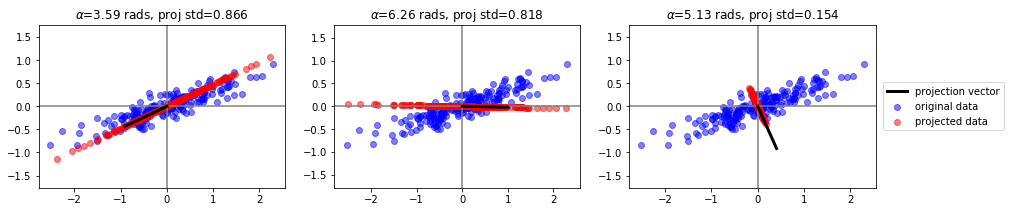

In [3]:
plt.figure(figsize=(15,3))

def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)])

for i in range(3):
    plt.subplot(1,3,i+1)
    angle = np.random.random()*np.pi*2
    v = unit_vector(angle)
    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
    Xp = np.repeat(v.reshape(-1,2),len(X),axis=0)*c
    plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
    plt.scatter(Xp[:,0], Xp[:,1], color="red", alpha=.5, label="projected data")
    plt.axvline(0, color="gray")
    plt.axhline(0, color="gray")
    plt.plot([0,v[0]], [0,v[1]], color="black", lw=3, label="projection vector")
    plt.axis('equal')
    plt.ylim(-2,2)
    plt.title("$\\alpha$=%.2f rads, proj std=%.3f"%(angle, np.std(c)))
    if i==2:
        plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

## Now the objective is to find the directions with the biggest and the lowest variance by inspection

In [4]:
def get_maxmin_projections(X):
    stds = []
    angles = np.linspace(0,np.pi*2, 300)
    for a in angles:
        v = np.array([np.cos(a), np.sin(a)])
        c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
        stds.append(np.std(c))
    v2 = unit_vector(angles[np.argmin(stds)])
    v1 = unit_vector(angles[np.argmax(stds)])
    
    return angles, stds, v1, v2

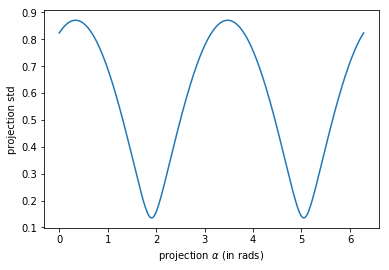

In [5]:
angles, stds, v1, v2 = get_maxmin_projections(X)

plt.plot(angles, stds)
plt.xlabel("projection $\\alpha$ (in rads)")
plt.ylabel("projection std")
plt.show()

So we take the one that maximize

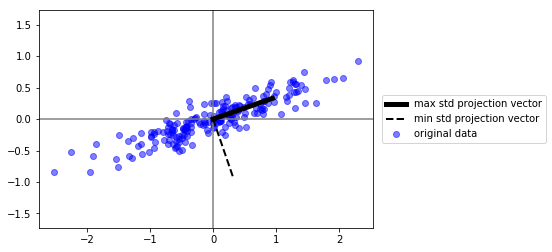

In [6]:
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.axvline(0, color="gray")
plt.axhline(0, color="gray")
plt.plot([0,v1[0]], [0,v1[1]], color="black", lw=5, label="max std projection vector")
plt.plot([0,v2[0]], [0,v2[1]], color="black", ls="--", lw=2, label="min std projection vector")
plt.axis('equal')
plt.ylim(-2,2)
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))
plt.show()

# Principal component Analysis (PCA)
The principal component analysis is a technique used to described a set of data in terms of new no correlated variables (components). The components are ordered from higher to lower variance that they explain. this technique is useful to reduce significantly the dimension of the set of data.

In other words, PCA try to find the projection over which the data is best represented in terms of minimum squares. This means that it transforms the set of observations (probably correlated) in a new set of variables without linear correlation. this is very well known when building predictive models.
### Limitations:
* Linearity: it is assumed that the observed data is a linear combination of a certain base.
* The criteria that it uses is build in the assumption that the data is Gaussian distributed therefore, the eigen-values 

# Recipe to Compute the PCA
1. once you have your data represented in a matrix form
$$
X=\begin{pmatrix}
 x_{11}& x_{12} &\ldots  & x_{1p}\\ 
 x_{21}& x_{22} &\ldots  & x_{2p} \\ 
 \vdots& \vdots & \vdots &\vdots \\ 
\vdots& \vdots & \vdots &\vdots \\ 
 x_{N1}& x_{N2} &\ldots& x_{Np} 
\end{pmatrix}
$$
we compute the vector of means
$$
\bar{X}=\frac{1}{N}\left[\sum_{i=1}^{N}x_{i1},\sum_{i=1}^{N}x_{i2},\ldots,\sum_{i=1}^{N}x_{pi}\right]
$$
and we compute $X_{norm}=X-\bar{X}$, here $X_{norm}$ means that we normalized the data by its mean.
2. We compute the covariance matrix given by $C=\frac{1}{N-1}(X_{norm}^{T}X_{norm})$.
3. compute the eigenvectors and eigenvalues of the covariance matrix and then project the data into those vectors.
4. choose the quantity of variance to keep and compute the Matrix projection and project your data into that space.
__Voilà __ you have reduced your dimension.

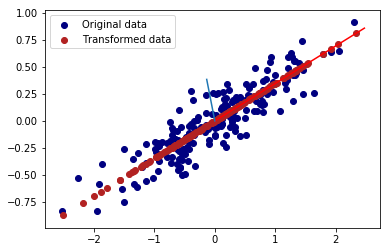

In [7]:
from numpy import linalg
# 1
X_bar=X.mean(axis=0)
# 2
C=((X-X_bar).T @ (X-X_bar))/(X.shape[0]-1)

# 3    
eig_vals,eig_vecs=linalg.eig(C)
#make a list of tuples with (eigenvalue, eigenvector)
eig_pair=[(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]
# sort from the highest to the lowest
eig_pairs=sorted(eig_pair,reverse=True)

# 4 We choose the quantity of variance explained

exp_var_percentage = 0.7 #70% of variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)] # compute the percentage of the variance explained by each eigenvalue
cum_var_exp = np.cumsum(var_exp)
# Compute the number of components (vectors) to keep such that coincide with the amount of variance we wanted
num_vec_to_keep = 0

for index, percentage in enumerate(cum_var_exp):
    if percentage > exp_var_percentage:
        num_vec_to_keep = index + 1
        break
        
# Compute the projection matrix based on the top eigen vectors

num_features = X.shape[1]
proj_mat = eig_pairs[0][1].reshape(num_features,1)
for eig_vec_idx in range(1, num_vec_to_keep):
    proj_mat = np.hstack((proj_mat, eig_pairs[eig_vec_idx][1].reshape(num_features,1)))

# Project the data 
pca_data = X.dot(proj_mat)

# finally plot how it will look

#plt.scatter(X[:,0],pca_data[:,0],color="red",label="Transformed data")
plt.scatter(X[:,0],X[:,1],color="navy",label="Original data")
plt.plot([0, 3*np.sqrt(eig_vals[0])*eig_vecs[0,0]],[0, 3*np.sqrt(eig_vals[0])*eig_vecs[1,0]],"r")
plt.plot([0, 3*np.sqrt(eig_vals[1])*eig_vecs[0,1]],[0, 3*np.sqrt(eig_vals[1])*eig_vecs[1,1]])
A=np.repeat(eig_vecs[:,0].reshape(-1,2),len(X),axis=0)*pca_data
plt.scatter(A[:,0],A[:,1],label="Transformed data",color="firebrick")
plt.legend()
plt.show()

# Exercise
Do the same with the data found in [here](https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv), it is useful to start from now on using the library Pandas. if you choose to do it by yourself, well done, download the data and read it from scratch, if you don't want to complicate the things. you can use the next command
```python
import pandas as pd
data=pd.read_csv("https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv")
```
see what is in data, you will see something similar to a sheet of Excel, something like

In [8]:

import pandas as pd
data=pd.read_csv("https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv")
data.head(5)

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


first you will need to delete from the data the column of "Wine", since this is just to know what kind of wine has those properties. Then in order to work with data in the same range, we can standardize the data, to each columns we are going to take each column and subtract the mean of each column, just as we did before, and divide each column to its respective standard deviation. ( to call a specific column in pandas we use data["name of column"]), the result should look something like this

In [9]:

data_norm=(data[data.columns[1:]]-data[data.columns[1:]].values.mean(axis=0))/data[data.columns[1:]].values.std(axis=0)
data_norm.head(5)

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Pandas allow us to make a plot of all variables and its combinations, it can be done by using the module of plotting in pandas( which under the hood is using matplotlib), so if we want to plot this we can use:
```python
d = pd.plotting.scatter_matrix(data_normalized, c=data["Wine"],figsize=(15, 15))
```

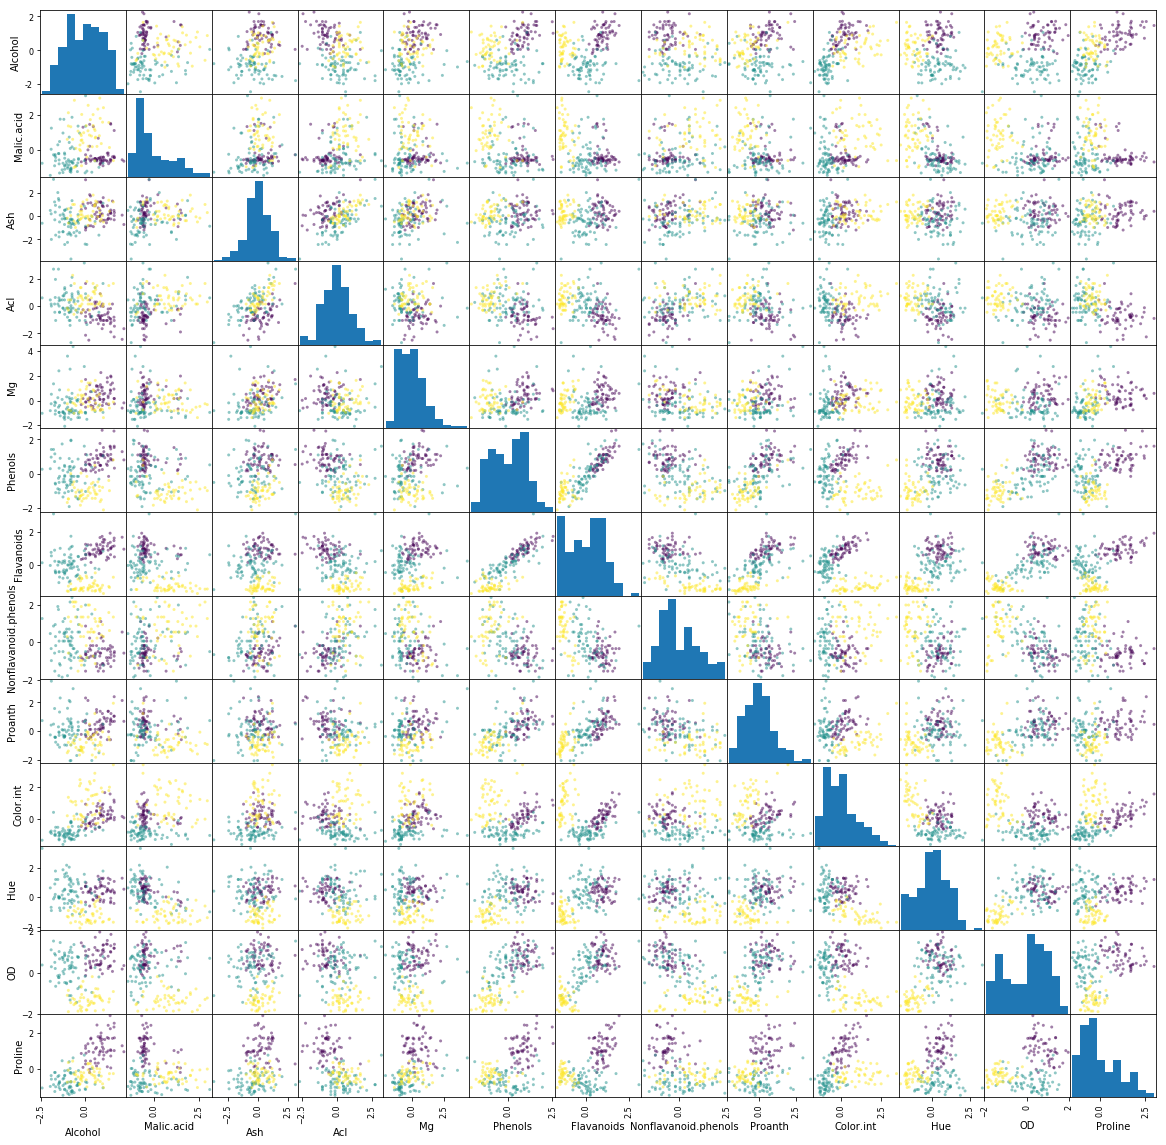

In [10]:

d= pd.plotting.scatter_matrix(data_norm,c=data["Wine"],figsize=(20,20))

where we have used the parameter "c" in the function to plot using the values of the wine column of the data set

Now your task is to implement a PCA as before but this time for the Wine data set.
* Compute the covariance matrix.
* Find the eigen-vectors ans eigen-values of that matrix.
* Plot the cumulative explained variance( it should look like this)

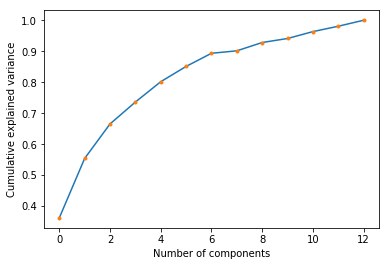

In [11]:
def make_PCA(data):
    d=data-data.mean(axis=0)
    C=d.T@d
    w,v=np.linalg.eig(C)
    return w,v
w,v=make_PCA(data_norm.values)
plt.plot(np.cumsum(w/w.sum()))
plt.plot(np.cumsum(w/w.sum()),".")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()
eig_pairs=[(w[i],v[:,i]) for i in range(len(w))]

* Now do take only the first two components of the data and plot component 1 vs component 2 of the PCA
__hint__: to visualize better the result color the point with the column "Wine" of the data set. use the following function to plot x,y (the data transformed X and the labels of the column wine).
```python
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")
```
The result looks like this ( ignore the error that appears):

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


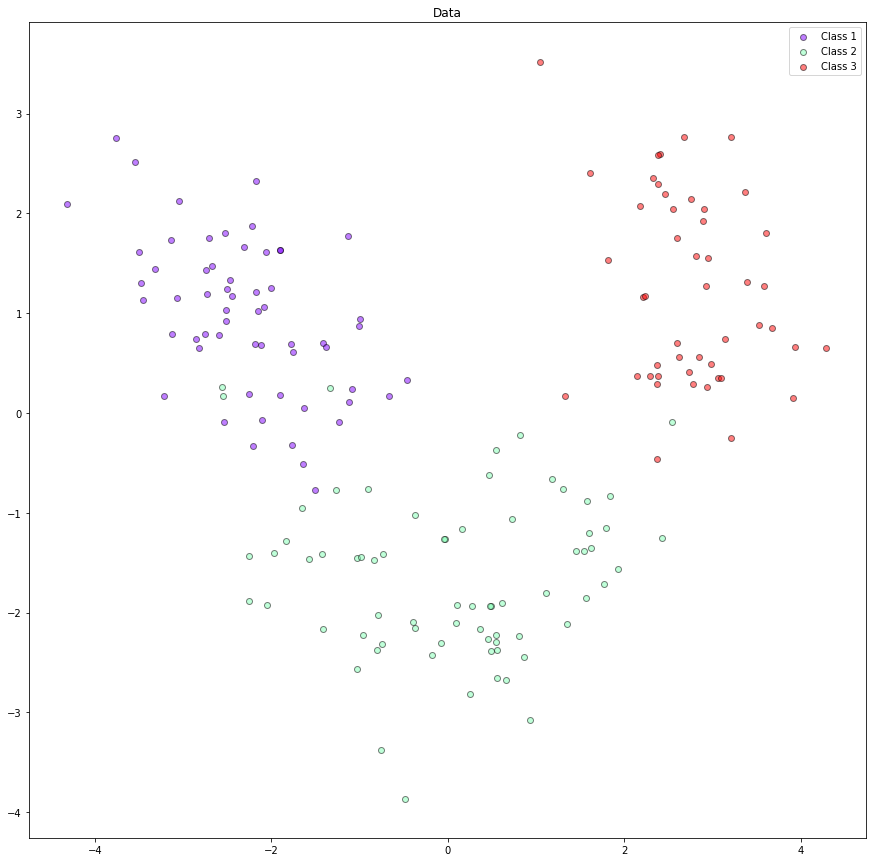

In [12]:

num_vec_to_keep=2
num_features = data_norm.shape[1]
proj_mat = eig_pairs[0][1].reshape(num_features,1)
for eig_vec_idx in range(1, num_vec_to_keep):
    proj_mat = np.hstack((proj_mat, eig_pairs[eig_vec_idx][1].reshape(num_features,1)))
pca_data = data_norm.values.dot(proj_mat)
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

plt.figure(figsize=(15,15))
plot_data(pca_data,data.Wine.values)
plt.show()

What can you conclude from the last plot?

The classes have been separated, so the computer learned via PCA algorith how to classify wines.